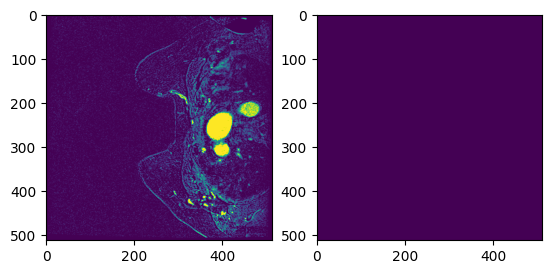

In [20]:
import numpy as np
from PIL import Image
import torch as torch
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import cv2
from einops import rearrange
from custom_transforms import *
import pydicom as dcm
from pydicom.pixel_data_handlers.util import apply_voi_lut
class tumor_Dataset(Dataset):
    def __init__(self,path):
        self.path = path

        self.train_path_list = []
        self.train_list = []

        self.label_path_list = []
        self.label_list = []

        self.target_path_list = []
        self.target_list = []

        self.train_path = path + "/input_dcm_standard"
        #self.label_path = path + "/breast"

        self.target_path = path + "/tumor_standard"
        
        for file in os.listdir(self.train_path):
            self.train_path_list.append(os.path.join(self.train_path,file))
        self.train_path_list.sort()
                
        # for file in os.listdir(self.label_path):
        #     self.label_path_list.append(os.path.join(self.label_path,file))           
        # self.label_path_list.sort()

        for file in os.listdir(self.target_path):
            self.target_path_list.append(os.path.join(self.target_path,file))           
        self.target_path_list.sort()

    def __len__(self):
        return len(self.target_path_list)
        
    def __getitem__(self,idx):

        mean = [0, ] # 예시 값
        std = [1, ]  # 예시 값

        self.transform = transforms.Compose([transforms.ToTensor(),
                                            transforms.Resize((512,512)),
                                            customRandomRotate(degrees=180,SEED=idx),
                                            #customRandomResizedCrop(SEED=idx,size=(256,256))
                                             ])
        normalized = transforms.Normalize(mean=mean,std=std)
        
        image_path = self.train_path_list[idx]

        slice = dcm.read_file(image_path)
        image = slice.pixel_array
        image = apply_voi_lut(image, slice)
        epsilon = 1e-10
        min_val = np.min(image)
        max_val = np.max(image)
        image = (image - min_val) / (max_val - min_val+epsilon)
        image = Image.fromarray(image)

        # label_path = self.label_path_list[idx]
        # label = np.array(Image.open(label_path).convert("L"))

        # label = Image.fromarray(label)

        target_path = self.target_path_list[idx]
        target = np.array(Image.open(target_path).convert("L"))

        target = Image.fromarray(target)

        input_image = self.transform(image)
        #input_image = normalized(input_image)
        #label_image = self.transform(label)
        target_image = self.transform(target)

        # thresh = np.zeros_like(label_image)
        # thresh[label_image > 0.5] = 1

        target_thresh = np.zeros_like(target_image)
        target_thresh[target_image > 0.5] =1

        #input_img = input_image*thresh

        return input_image, target_thresh
    
path = "/workspace/breast_mri/2d_train/only_tumor"
dataset = tumor_Dataset(path)
dataloader = DataLoader(dataset,batch_size=1,shuffle=True)

sample = next(iter(dataloader))

plt.subplot(1,2,1)
plt.imshow(np.array(sample[0]).squeeze())
plt.subplot(1,2,2)
plt.imshow(np.array(sample[1]).squeeze())